In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from PIL import Image
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/QBIO\ 465\ FP/Original /content/

In [ ]:
dataset_path = "Original"

classes = ["Benign", "Early", "Pre", "Pro"]

image_counts = {}
image_paths = defaultdict(list)

for cls in classes:
    folder = os.path.join(dataset_path, cls)
    files = [f for f in os.listdir(folder) if f.endswith(".jpg") or f.endswith(".png")]
    image_counts[cls] = len(files)
    image_paths[cls] = [os.path.join(folder, f) for f in files]

In [ ]:
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

augmented_dir = '/content/Original/Benign/augmented'
shutil.rmtree(augmented_dir, ignore_errors=True)
os.makedirs(augmented_dir, exist_ok=True)

benign_dir = '/content/Original/Benign'
original_images = [f for f in os.listdir(benign_dir) if f.endswith('.jpg') and not f.startswith('aug_')]

for img_name in original_images:
    src_path = os.path.join(benign_dir, img_name)
    dst_path = os.path.join(augmented_dir, img_name)
    shutil.copy(src_path, dst_path)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    brightness_range=(0.95, 1.05),
    fill_mode='nearest'
)

target_count = 900
current_images = os.listdir(augmented_dir)
num_to_generate = target_count - len(current_images)
generated = 0

for img_name in original_images:
    img_path = os.path.join(benign_dir, img_name)
    img = load_img(img_path)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    i = 0
    for batch in datagen.flow(x, batch_size=1):
        save_path = os.path.join(augmented_dir, f"aug_{img_name.split('.')[0]}_{i}.jpg")
        save_img(save_path, batch[0])
        i += 1
        generated += 1
        if generated >= num_to_generate:
            break
    if generated >= num_to_generate:
        break

print(f"Final number of Benign images: {len(os.listdir(augmented_dir))}")


Final number of Benign images: 900


In [ ]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

classes = ['Benign', 'Early', 'Pre', 'Pro']
data_dir = '/content/Original/'

image_paths = []
labels = []

for cls in classes:
    folder = os.path.join(data_dir, cls, 'augmented') if cls == 'Benign' else os.path.join(data_dir, cls)
    for fname in os.listdir(folder):
        if fname.endswith('.jpg'):
            image_paths.append(os.path.join(folder, fname))
            labels.append(cls)



In [ ]:
img_size = (224, 224)

def load_images(paths, size):
    images = []
    for path in paths:
        img = Image.open(path).resize(size)
        images.append(np.array(img))
    return np.array(images)

X = load_images(image_paths, img_size)
X = X.astype('float32') / 255.0

le = LabelEncoder()
y = le.fit_transform(labels)
y_cat = to_categorical(y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (2921, 224, 224, 3)
Test shape: (731, 224, 224, 3)


# Flatenned Images

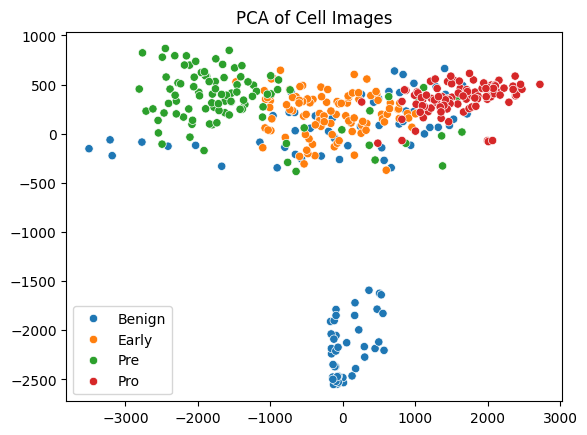

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def extract_flattened_images(paths, labels, num=100):
    X, y = [], []
    class_counts = {}

    for img_path, label in zip(paths, labels):
        if class_counts.get(label, 0) >= num:
            continue
        try:
            img = Image.open(img_path).resize((64, 64))
            X.append(np.array(img).flatten())
            y.append(label)
            class_counts[label] = class_counts.get(label, 0) + 1
        except Exception as e:
            print(f"Error with {img_path}: {e}")

    return np.array(X), np.array(y)

X_flat, y_labels = extract_flattened_images(image_paths, labels, num=100)
X_pca = PCA(n_components=2).fit_transform(X_flat)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_labels)
plt.title("PCA of Cell Images")
plt.show()

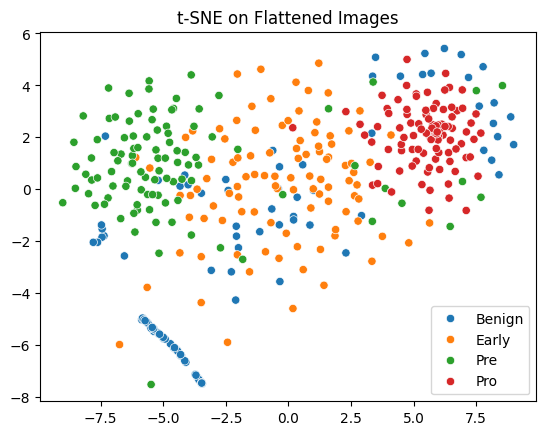

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_flat)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_labels)
plt.title("t-SNE on Flattened Images")
plt.show()